In [4]:
import tensorflow as tf
#import tensorflow_federated as tff
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.cluster import DBSCAN

# Define the metrics function
def perform_differential_testing(predictions_i, predictions_j, labels, data_type):
    pred_class_i = np.argmax(predictions_i, axis=1)
    pred_class_j = np.argmax(predictions_j, axis=1)
    
    Δ_class = np.sum(pred_class_i != pred_class_j)
    Δ_score = np.sum(predictions_i != predictions_j)
    P_KS = ks_2samp(predictions_i.flatten(), predictions_j.flatten()).pvalue
    contingency = np.array([[np.sum((pred_class_i == k) & (pred_class_j == l)) for l in range(10)] for k in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    return Δ_class, Δ_score, P_KS, P_X2

# Function to determine if a model is an outlier using DBSCAN
def is_outlier(metric_data, epsilon=0.2, min_samples=2):
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(metric_data)
    outliers = clusters == -1  # Outliers are labeled as -1 by DBSCAN
    return outliers

# Function to perform the federated learning process
def federated_learning_process(server_model, client_data, epsilon=0.8, min_samples=2):
    server_predictions = server_model.predict(server_test_data)

    # Store metrics for all clients
    metrics_data = []

    for client_id, client_model in enumerate(client_data):
        client_predictions = client_model.predict(server_test_data)
        Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(
            server_predictions, client_predictions, server_test_labels, f"Client {client_id}"
        )
        metrics_data.append([Δ_class, Δ_score, P_KS, P_X2])

    # Convert metrics data to numpy array
    metrics_data = np.array(metrics_data)
    
    # Check for outliers
    outliers = is_outlier(metrics_data, epsilon=epsilon, min_samples=min_samples)
    
    for i, outlier in enumerate(outliers):
        if outlier:
            print(f"Client {i} is an outlier.")

# Simulated federated learning setup
def create_fake_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Simulated test data on server
server_test_data = np.random.random((100, 20))  # 100 samples, 20 features each
server_test_labels = np.random.randint(0, 10, 100)  # 100 labels for 10 classes

# Simulated client models
client_models = [create_fake_model() for _ in range(10)]  # 5 clients

# Perform federated learning process
federated_learning_process(server_model=create_fake_model(), client_data=client_models)


4/4 [==============================] - 0s 5ms/step
Client 1 is an outlier.
Client 2 is an outlier.
Client 3 is an outlier.
Client 4 is an outlier.
Client 5 is an outlier.
Client 8 is an outlier.


In [2]:
import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.cluster import DBSCAN

# Define the metrics function
def perform_differential_testing(predictions_i, predictions_j, labels, data_type):
    pred_class_i = np.argmax(predictions_i, axis=1)
    pred_class_j = np.argmax(predictions_j, axis=1)
    
    Δ_class = np.sum(pred_class_i != pred_class_j)
    Δ_score = np.sum(predictions_i != predictions_j)
    P_KS = ks_2samp(predictions_i.flatten(), predictions_j.flatten()).pvalue
    contingency = np.array([[np.sum((pred_class_i == k) & (pred_class_j == l)) for l in range(10)] for k in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    return Δ_class, Δ_score, P_KS, P_X2

# Function to determine if a model is an outlier using DBSCAN
def is_outlier(metric_data, epsilon=0.2, min_samples=2):
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(metric_data)
    outliers = clusters == -1  # Outliers are labeled as -1 by DBSCAN
    return outliers

# Function to perform the federated learning process
def federated_learning_process(server_model, client_data, epsilon=0.8, min_samples=2):
    server_predictions = server_model.predict(server_test_data)
    server_predictions = np.argmax(server_predictions, axis=1)

    # Store metrics for all clients
    metrics_data = []

    for client_id, client_model in enumerate(client_data):
        client_predictions = client_model.predict(server_test_data)
        Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(
            server_predictions, client_predictions, server_test_labels, f"Client {client_id}"
        )
        metrics_data.append([Δ_class, Δ_score, P_KS, P_X2])

    # Convert metrics data to numpy array
    metrics_data = np.array(metrics_data)
    
    # Check for outliers
    outliers = is_outlier(metrics_data, epsilon=epsilon, min_samples=min_samples)
    
    for i, outlier in enumerate(outliers):
        if outlier:
            print(f"Warning: Client {i} is an outlier. Potential bug detected.")
            return  # Stop the process if an outlier is detected

# Simulated federated learning setup
def create_fake_model(bug=False):
    if bug:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu')  # Incorrect activation function
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Simulated test data on server
server_test_data = np.random.random((100, 20))  # 100 samples, 20 features each
server_test_labels = np.random.randint(0, 10, 100)  # 100 labels for 10 classes

# Simulated client models
client_models = [create_fake_model(bug=(i == 0)) for i in range(10)]  # Introduce bug in the first client

# Train client models
for client_model in client_models:
    client_model.fit(server_test_data, server_test_labels, epochs=1, verbose=0)

# Perform federated learning process
federated_learning_process(server_model=create_fake_model(), client_data=client_models)


4/4 [==============================] - 0s 2ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [5]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

In [6]:
class FederatedModel:
    def __init__(self, num_clients):
        self.num_clients = num_clients
        self.client_models = [self.create_model() for _ in range(num_clients)]
        self.global_model = self.create_model()

    def create_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(20,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, client_data, client_labels, epochs=5):
        for i in range(self.num_clients):
            self.client_models[i].fit(client_data[i], client_labels[i], epochs=epochs, verbose=0)
        
        # Aggregate weights (simple average for demonstration)
        weights = [model.get_weights() for model in self.client_models]
        averaged_weights = [np.mean(weights_list, axis=0) for weights_list in zip(*weights)]
        self.global_model.set_weights(averaged_weights)

    def predict(self, x):
        return self.global_model.predict(x)

In [7]:
def differential_testing(federated_model, centralized_model, test_data, test_labels):
    fed_predictions = federated_model.predict(test_data)
    cent_predictions = centralized_model.predict(test_data)

    fed_accuracy = accuracy_score(test_labels, np.argmax(fed_predictions, axis=1))
    cent_accuracy = accuracy_score(test_labels, np.argmax(cent_predictions, axis=1))

    ks_statistic, p_value = ks_2samp(fed_predictions.flatten(), cent_predictions.flatten())

    return fed_accuracy, cent_accuracy, ks_statistic, p_value

def detect_anomalies(federated_model, test_data):
    client_predictions = [model.predict(test_data) for model in federated_model.client_models]
    client_predictions_flat = [pred.flatten() for pred in client_predictions]
    
    dbscan = DBSCAN(eps=0.5, min_samples=2)
    clusters = dbscan.fit_predict(client_predictions_flat)
    
    anomalies = np.where(clusters == -1)[0]
    return anomalies

def plot_performance(federated_accuracies, centralized_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(federated_accuracies, label='Federated')
    plt.plot(centralized_accuracies, label='Centralized')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Federated vs Centralized Learning Performance')
    plt.legend()
    plt.show()

In [9]:
from scipy.stats import wasserstein_distance

def compare_client_with_server(federated_model, test_data, test_labels):
    server_predictions = federated_model.predict(test_data)
    server_accuracy = accuracy_score(test_labels, np.argmax(server_predictions, axis=1))
    
    results = []
    for i, client_model in enumerate(federated_model.client_models):
        client_predictions = client_model.predict(test_data)
        client_accuracy = accuracy_score(test_labels, np.argmax(client_predictions, axis=1))
        
        accuracy_diff = server_accuracy - client_accuracy
        
        ks_statistic, p_value = ks_2samp(server_predictions.flatten(), client_predictions.flatten())
        
        w_distance = wasserstein_distance(server_predictions.flatten(), client_predictions.flatten())
        
        results.append({
            'client_id': i,
            'accuracy_diff': accuracy_diff,
            'ks_statistic': ks_statistic,
            'ks_p_value': p_value,
            'wasserstein_distance': w_distance
        })
    
    return results

Epoch 1
16/16 [==============================] - 0s 2ms/step
Federated Accuracy: 0.1080
Centralized Accuracy: 0.0820
KS Statistic: 0.3154, p-value: 0.0000
16/16 [==============================] - 0s 2ms/step
Anomalous clients detected: [0 1 2 3 4]
16/16 [==============================] - 0s 5ms/step

Client vs Server Comparison:
Client 0:
  Accuracy Difference: 0.0080
  KS Statistic: 0.4284, p-value: 0.0000
  Wasserstein Distance: 0.0106
Client 1:
  Accuracy Difference: 0.0160
  KS Statistic: 0.3988, p-value: 0.0000
  Wasserstein Distance: 0.0107
Client 2:
  Accuracy Difference: 0.0080
  KS Statistic: 0.4016, p-value: 0.0000
  Wasserstein Distance: 0.0099
Client 3:
  Accuracy Difference: 0.0220
  KS Statistic: 0.4440, p-value: 0.0000
  Wasserstein Distance: 0.0113
Client 4:
  Accuracy Difference: 0.0200
  KS Statistic: 0.4012, p-value: 0.0000
  Wasserstein Distance: 0.0081

Epoch 2
16/16 [==============================] - 0s 2ms/step
Federated Accuracy: 0.1080
Centralized Accuracy: 0.0

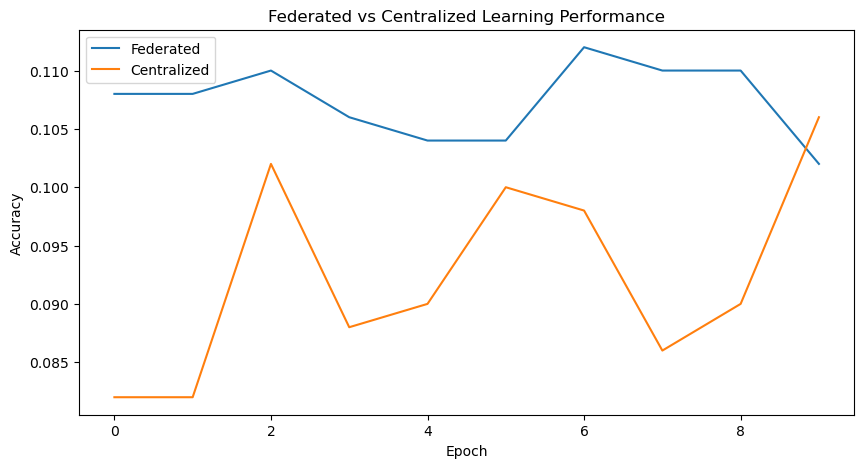

In [10]:
def main():
    # Generate synthetic data
    num_clients = 5
    num_samples = 1000
    num_features = 20
    num_classes = 10

    client_data = [np.random.rand(num_samples, num_features) for _ in range(num_clients)]
    client_labels = [np.random.randint(0, num_classes, num_samples) for _ in range(num_clients)]

    test_data = np.random.rand(500, num_features)
    test_labels = np.random.randint(0, num_classes, 500)

    # Create and train models
    federated_model = FederatedModel(num_clients)
    centralized_model = federated_model.create_model()

    all_data = np.concatenate(client_data)
    all_labels = np.concatenate(client_labels)

    federated_accuracies = []
    centralized_accuracies = []

    for epoch in range(10):
        print(f"Epoch {epoch + 1}")
        
        # Train federated model
        federated_model.train(client_data, client_labels)
        
        # Train centralized model
        centralized_model.fit(all_data, all_labels, epochs=1, verbose=0)
        
        # Perform differential testing
        fed_acc, cent_acc, ks_stat, p_value = differential_testing(federated_model, centralized_model, test_data, test_labels)
        federated_accuracies.append(fed_acc)
        centralized_accuracies.append(cent_acc)
        
        print(f"Federated Accuracy: {fed_acc:.4f}")
        print(f"Centralized Accuracy: {cent_acc:.4f}")
        print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")
        
        # Detect anomalies
        anomalies = detect_anomalies(federated_model, test_data)
        if len(anomalies) > 0:
            print(f"Anomalous clients detected: {anomalies}")
        
        # Compare client models with server model
        comparison_results = compare_client_with_server(federated_model, test_data, test_labels)
        print("\nClient vs Server Comparison:")
        for result in comparison_results:
            print(f"Client {result['client_id']}:")
            print(f"  Accuracy Difference: {result['accuracy_diff']:.4f}")
            print(f"  KS Statistic: {result['ks_statistic']:.4f}, p-value: {result['ks_p_value']:.4f}")
            print(f"  Wasserstein Distance: {result['wasserstein_distance']:.4f}")
        
        print()

    # Plot performance
    plot_performance(federated_accuracies, centralized_accuracies)

if __name__ == "__main__":
    main()

introducing the bug in activation function of the client models

In [5]:
import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.cluster import DBSCAN

# Define the metrics function
def perform_differential_testing(predictions_i, predictions_j, labels, data_type):
    if predictions_i.ndim == 1:
        predictions_i = np.expand_dims(predictions_i, axis=1)
    if predictions_j.ndim == 1:
        predictions_j = np.expand_dims(predictions_j, axis=1)
    
    pred_class_i = np.argmax(predictions_i, axis=1)
    pred_class_j = np.argmax(predictions_j, axis=1)
    
    Δ_class = np.sum(pred_class_i != pred_class_j)
    Δ_score = np.sum(predictions_i != predictions_j)
    P_KS = ks_2samp(predictions_i.flatten(), predictions_j.flatten()).pvalue
    contingency = np.array([[np.sum((pred_class_i == k) & (pred_class_j == l)) for l in range(10)] for k in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    return Δ_class, Δ_score, P_KS, P_X2

# Function to determine if a model is an outlier using DBSCAN
def is_outlier(metric_data, epsilon=0.2, min_samples=2):
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(metric_data)
    outliers = clusters == -1  # Outliers are labeled as -1 by DBSCAN
    return outliers

# Function to perform the federated learning process
def federated_learning_process(server_model, client_data, epsilon=0.8, min_samples=2):
    server_predictions = server_model.predict(server_test_data)
    server_predictions = np.argmax(server_predictions, axis=1)

    # Store metrics for all clients
    metrics_data = []

    for client_id, client_model in enumerate(client_data):
        client_predictions = client_model.predict(server_test_data)
        if client_predictions.ndim == 1:
            client_predictions = np.expand_dims(client_predictions, axis=1)
        client_predictions = np.argmax(client_predictions, axis=1)  # Ensure correct dimensions
        Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(
            server_predictions, client_predictions, server_test_labels, f"Client {client_id}"
        )
        metrics_data.append([Δ_class, Δ_score, P_KS, P_X2])

    # Convert metrics data to numpy array
    metrics_data = np.array(metrics_data)
    
    # Check for outliers
    outliers = is_outlier(metrics_data, epsilon=epsilon, min_samples=min_samples)
    
    for i, outlier in enumerate(outliers):
        if outlier:
            print(f"Warning: Client {i} is an outlier. Potential bug detected.")
            return  # Stop the process if an outlier is detected

# Simulated federated learning setup
def create_fake_model(bug=False):
    if bug:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu')  # Incorrect activation function
        ])
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Simulated test data on server
server_test_data = np.random.random((100, 20))  # 100 samples, 20 features each
server_test_labels = np.random.randint(0, 10, 100)  # 100 labels for 10 classes

# Simulated client models
client_models = [create_fake_model(bug=(i == 2)) for i in range(10)]  # Introduce bug in the first client

# Train client models
for client_model in client_models:
    client_model.fit(server_test_data, server_test_labels, epochs=1, verbose=0)

# Perform federated learning process
federated_learning_process(server_model=create_fake_model(), client_data=client_models)


4/4 [==============================] - 0s 1ms/step


introduce a bug in the learning rate

In [6]:
import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.cluster import DBSCAN

# Define the metrics function
def perform_differential_testing(predictions_i, predictions_j, labels, data_type):
    if predictions_i.ndim == 1:
        predictions_i = np.expand_dims(predictions_i, axis=1)
    if predictions_j.ndim == 1:
        predictions_j = np.expand_dims(predictions_j, axis=1)
    
    pred_class_i = np.argmax(predictions_i, axis=1)
    pred_class_j = np.argmax(predictions_j, axis=1)
    
    Δ_class = np.sum(pred_class_i != pred_class_j)
    Δ_score = np.sum(predictions_i != predictions_j)
    P_KS = ks_2samp(predictions_i.flatten(), predictions_j.flatten()).pvalue
    contingency = np.array([[np.sum((pred_class_i == k) & (pred_class_j == l)) for l in range(10)] for k in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    return Δ_class, Δ_score, P_KS, P_X2

# Function to determine if a model is an outlier using DBSCAN
def is_outlier(metric_data, epsilon=0.2, min_samples=2):
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(metric_data)
    outliers = clusters == -1  # Outliers are labeled as -1 by DBSCAN
    return outliers

# Function to perform the federated learning process
def federated_learning_process(server_model, client_data, epsilon=0.8, min_samples=2):
    server_predictions = server_model.predict(server_test_data)
    server_predictions = np.argmax(server_predictions, axis=1)

    # Store metrics for all clients
    metrics_data = []

    for client_id, client_model in enumerate(client_data):
        client_predictions = client_model.predict(server_test_data)
        if client_predictions.ndim == 1:
            client_predictions = np.expand_dims(client_predictions, axis=1)
        client_predictions = np.argmax(client_predictions, axis=1)  # Ensure correct dimensions
        Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(
            server_predictions, client_predictions, server_test_labels, f"Client {client_id}"
        )
        metrics_data.append([Δ_class, Δ_score, P_KS, P_X2])

    # Convert metrics data to numpy array
    metrics_data = np.array(metrics_data)
    
    # Check for outliers
    outliers = is_outlier(metrics_data, epsilon=epsilon, min_samples=min_samples)
    
    for i, outlier in enumerate(outliers):
        if outlier:
            print(f"Warning: Client {i} is an outlier. Potential bug detected.")
            return  # Stop the process if an outlier is detected

# Simulated federated learning setup
def create_fake_model(bug=False):
    if bug:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=10.0)  # Extremely high learning rate
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Normal learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Simulated test data on server
server_test_data = np.random.random((100, 20))  # 100 samples, 20 features each
server_test_labels = np.random.randint(0, 10, 100)  # 100 labels for 10 classes

# Simulated client models
client_models = [create_fake_model(bug=(i == 0)) for i in range(10)]  # Introduce bug in the first client

# Train client models
for client_model in client_models:
    client_model.fit(server_test_data, server_test_labels, epochs=1, verbose=0)

# Perform federated learning process
federated_learning_process(server_model=create_fake_model(), client_data=client_models)


4/4 [==============================] - 0s 1ms/step


In [7]:
import tensorflow as tf
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.cluster import DBSCAN

# Define the metrics function
def perform_differential_testing(predictions_i, predictions_j, labels, data_type):
    if predictions_i.ndim == 1:
        predictions_i = np.expand_dims(predictions_i, axis=1)
    if predictions_j.ndim == 1:
        predictions_j = np.expand_dims(predictions_j, axis=1)
    
    pred_class_i = np.argmax(predictions_i, axis=1)
    pred_class_j = np.argmax(predictions_j, axis=1)
    
    Δ_class = np.sum(pred_class_i != pred_class_j)
    Δ_score = np.sum(predictions_i != predictions_j)
    P_KS = ks_2samp(predictions_i.flatten(), predictions_j.flatten()).pvalue
    contingency = np.array([[np.sum((pred_class_i == k) & (pred_class_j == l)) for l in range(10)] for k in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    return Δ_class, Δ_score, P_KS, P_X2

# Function to determine if a model is an outlier using DBSCAN
def is_outlier(metric_data, epsilon=0.2, min_samples=2):
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(metric_data)
    outliers = clusters == -1  # Outliers are labeled as -1 by DBSCAN
    return outliers

# Function to perform the federated learning process
def federated_learning_process(server_model, client_data, epsilon=0.8, min_samples=2):
    server_predictions = server_model.predict(server_test_data)
    server_predictions = np.argmax(server_predictions, axis=1)

    # Store metrics for all clients
    metrics_data = []

    for client_id, client_model in enumerate(client_data):
        client_predictions = client_model.predict(server_test_data)
        if client_predictions.ndim == 1:
            client_predictions = np.expand_dims(client_predictions, axis=1)
        client_predictions = np.argmax(client_predictions, axis=1)  # Ensure correct dimensions
        Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(
            server_predictions, client_predictions, server_test_labels, f"Client {client_id}"
        )
        metrics_data.append([Δ_class, Δ_score, P_KS, P_X2])

    # Convert metrics data to numpy array
    metrics_data = np.array(metrics_data)
    
    # Check for outliers
    outliers = is_outlier(metrics_data, epsilon=epsilon, min_samples=min_samples)
    
    for i, outlier in enumerate(outliers):
        if outlier:
            print(f"Warning: Client {i} is an outlier. Potential bug detected.")
            return  # Stop the process if an outlier is detected

# Simulated federated learning setup
def create_fake_model(bug=False):
    if bug:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=10.0)  # Extremely high learning rate
    else:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Normal learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Simulated test data on server
server_test_data = np.random.random((100, 20))  # 100 samples, 20 features each
server_test_labels = np.random.randint(0, 10, 100)  # 100 labels for 10 classes

# Simulated client models
client_models = [create_fake_model(bug=(i == 0)) for i in range(10)]  # Introduce bug in the first client

# Train client models
for client_model in client_models:
    client_model.fit(server_test_data, server_test_labels, epochs=1, verbose=0)

# Perform federated learning process
federated_learning_process(server_model=create_fake_model(), client_data=client_models)


4/4 [==============================] - 0s 2ms/step
